In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [95]:

def load_and_crop_images(image_path1, image_path2):
    img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    
    if img1 is None or img2 is None:
        raise ValueError(f"Failed to load one or both images from paths: {image_path1}, {image_path2}")

    # Visualize the original images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Image 1")
    plt.imshow(img1, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Image 2")
    plt.imshow(img2, cmap='gray')
    plt.axis('off')

    plt.show()
    
    # Crop images to centered area
    img1_cropped = crop_center(img1)
    img2_cropped = crop_center(img2)

    # Visualize the cropped images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Cropped Image 1")
    plt.imshow(img1_cropped, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Cropped Image 2")
    plt.imshow(img2_cropped, cmap='gray')
    plt.axis('off')

    plt.show()
    
    return img1_cropped, img2_cropped

In [96]:
def crop_center(image):
    h, w = image.shape[:2]
    start_h = h // 3
    end_h = 2 * h // 3
    start_w = w // 3
    end_w = 2 * w // 3

    cropped_image = image[start_h:end_h, start_w:end_w]

    
    return cropped_image

In [97]:
def find_keypoints_and_matches(img1, img2):
    # Initialize ORB detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Use BFMatcher to find matches
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    return kp1, kp2, matches

In [98]:
def get_matched_points(kp1, kp2, matches):
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 2)
    return src_pts, dst_pts

In [99]:
def estimate_affine_transform(src_pts, dst_pts):
    M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts)
    return M

In [100]:
def decompose_affine_matrix(M):
    scale_x = np.sqrt(M[0, 0]**2 + M[0, 1]**2)
    scale_y = np.sqrt(M[1, 0]**2 + M[1, 1]**2)
    # shear = M[0, 0] * M[1, 0] + M[0, 1] * M[1, 1]
    # theta = np.arctan2(M[1, 0], M[1, 1])
    shear = np.arctan2(M[0, 1], M[0, 0])
    theta = np.arctan2(M[1, 0], M[1, 1])
    return scale_x, scale_y, shear, theta

In [101]:
def calculate_skew_effect(M):
    # Calculate the skew component
    shear_x = M[0, 1]
    shear_y = M[1, 0]
    
    # Calculate the percentage skew based on the original distance
    skew_effect = np.sqrt(shear_x**2 + shear_y**2)
    skew_percentage = skew_effect * 100  # To convert to percentage
    
    return skew_effect, skew_percentage

In [102]:

def main(image_path1, image_path2):
    try:
        img1, img2 = load_and_crop_images(image_path1, image_path2)
    except ValueError as e:
        print(e)
        return
        
    kp1, kp2, matches = find_keypoints_and_matches(img1, img2)
    src_pts, dst_pts = get_matched_points(kp1, kp2, matches)
    M = estimate_affine_transform(src_pts, dst_pts)

    if M is not None:
        scale_x, scale_y, shear, theta = decompose_affine_matrix(M)
        skew_effect, skew_percentage = calculate_skew_effect(M)
        
        print(f"Affine Transformation Matrix:\n{M}")
        # print(f"Scale X: {scale_x}")
        # print(f"Scale Y: {scale_y}")
        # print(f"Shear: {shear}")
        # print(f"Rotation (radians): {theta}")
        # print(f"Skew Effect: {skew_effect:.4f}")
        # print(f"Skew Effect Percentage: {skew_percentage:.2f}%")
    else:
        print("Affine transformation could not be estimated.")

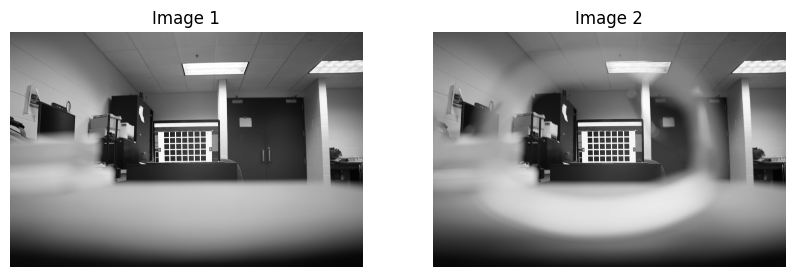

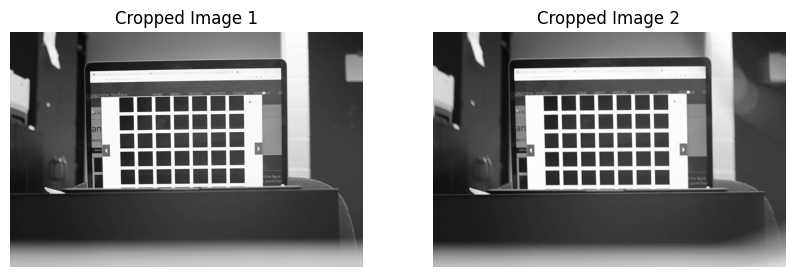

Affine Transformation Matrix:
[[ 1.02741323e+00 -6.05176578e-03 -4.64356044e+00]
 [ 6.05176578e-03  1.02741323e+00 -2.31631278e+01]]


In [103]:
if __name__ == "__main__":
    image_path1 = 'grid_wo.jpg'
    image_path2 = 'grid_w.jpg'
    main(image_path1, image_path2)